In [15]:
# !pip install tensorflow-gpu==2.9.3

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ---------------------------------------- 0.0/444.1 MB ? eta -:--:--
     ---------------------------------------- 0.1/444.1 MB 1.7 MB/s eta 0:04:29
     ---------------------------------------- 0.1/444.1 MB 1.7 MB/s eta 0:04:21
     ---------------------------------------- 0.2/444.1 MB 1.6 MB/s eta 0:04:38
     ---------------------------------------- 0.3/444.1 MB 1.8 MB/s eta 0:04:09
     ---------------------------------------- 0.4/444.1 MB 1.8 MB/s eta 0:04:10
     ---------------------------------------- 0.5/444.1 MB 1.8 MB/s eta 0:04:11
     ---------------------------------------- 0.6/444.1 MB 1.8 MB/s eta 0:04:12
     ---------------------------------------- 0.6/444.1 MB 1.8 MB/s eta 0:04:11
     ---------------------------------------- 0.7/444.1 MB 1.8 MB/s eta 0:04:12
     ---------------------------------------- 0.8/444.1 MB 1.8 MB/s eta 0:04:12
     ---------------------------------------- 0.9/444.

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\tensorflow\\~-te\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split

In [2]:
load_path='F:/VA/106words_ycbcr/'
CATEGORIES=np.load(load_path+'cat_106_ycbcr.npy', allow_pickle=True)

cat_len=len(CATEGORIES)
print(cat_len)
X=np.load(load_path+'X_ycbcr.npy', allow_pickle=True)
Y=np.load(load_path+'Y_ycbcr.npy', allow_pickle=True)
# X = X.astype('float32')
# X /= 255

106


In [3]:
IMG_SIZE=224

In [4]:
Y_new=[]
for i in range(len(X)):
    index = (Y[i].tolist()).index(1)
    Y_new.append(index)
len(Y_new)

Y=np.array(Y_new)
print(Y.shape)

(31800,)


In [5]:
print('Splitting') 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = cat_len)
X_train, X_new, y_train, y_new = train_test_split(X_train, y_train, test_size = 0.2, random_state = cat_len)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_new = np.array(X_new)
y_new = np.array(y_new)

print("pass")
del X,Y

Splitting
pass


In [6]:
num_classes = cat_len
input_shape = (IMG_SIZE, IMG_SIZE, 1)
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 100
num_epochs = 500
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
# mlp_head_units = [4096, 2048] 
# mlp_head_units = [1024, 512] 

In [7]:
# print('Image Data Augmentation')
# from keras.preprocessing.image import ImageDataGenerator
# val_generator = ImageDataGenerator(rotation_range=0, zoom_range=0.2, width_shift_range=0.2,
#     height_shift_range=0.2, shear_range=0.2, resize=(image_size, image_size,3))
# #                                     , horizontal_flip=True, brightness_range=[0.6,1.3])
# val_generator.fit(X_train)
# val_generator.fit(X_new)
# val_generator.fit(X_test)

# print("done")

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size)
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.02),
#         layers.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
    ],
    name="data_augmentation",
)
# # Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


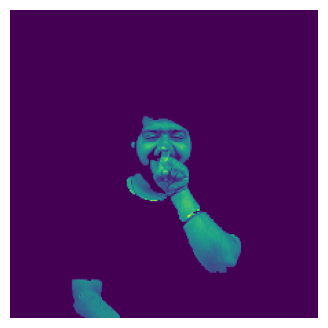

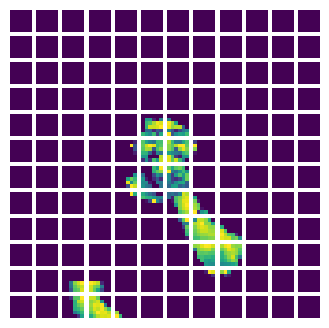

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow((image).astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [14]:
from tensorflow.keras.optimizers import Adam
from keras import callbacks
def run_experiment(model):
#     optimizer = tfa.optimizers.AdamW(
#         learning_rate=learning_rate, weight_decay=weight_decay
#     )
    
    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )
    earlystopping = callbacks.EarlyStopping(monitor="val_loss", patience = 5, restore_best_weights = True)
#     checkpoint_filepath = load_path+"tmp"
#     checkpoint_callback = keras.callbacks.ModelCheckpoint(
#         checkpoint_filepath,
#         monitor="val_accuracy",
#         save_best_only=True,
#         save_weights_only=True,
#     )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[earlystopping],
    )

#     model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model, history


vit_classifier = create_vit_classifier()
model, history = run_experiment(vit_classifier)

Epoch 1/500
161/161 [==============================] - 12s 37ms/step - loss: 4.8702 - accuracy: 0.0278 - top-5-accuracy: 0.0980 - val_loss: 4.2158 - val_accuracy: 0.1656 - val_top-5-accuracy: 0.4076
Epoch 2/500
161/161 [==============================] - 5s 33ms/step - loss: 3.9141 - accuracy: 0.1173 - top-5-accuracy: 0.3025 - val_loss: 2.7612 - val_accuracy: 0.4037 - val_top-5-accuracy: 0.7271
Epoch 3/500
161/161 [==============================] - 5s 33ms/step - loss: 2.9769 - accuracy: 0.2661 - top-5-accuracy: 0.5400 - val_loss: 1.8639 - val_accuracy: 0.6002 - val_top-5-accuracy: 0.8574
Epoch 4/500
161/161 [==============================] - 5s 33ms/step - loss: 2.3214 - accuracy: 0.3874 - top-5-accuracy: 0.6940 - val_loss: 1.3152 - val_accuracy: 0.7221 - val_top-5-accuracy: 0.9231
Epoch 5/500
161/161 [==============================] - 5s 33ms/step - loss: 1.8287 - accuracy: 0.4975 - top-5-accuracy: 0.7901 - val_loss: 0.9440 - val_accuracy: 0.7934 - val_top-5-accuracy: 0.9500
Epoch 6/5

161/161 [==============================] - 5s 33ms/step - loss: 0.0368 - accuracy: 0.9888 - top-5-accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 0.9949 - val_top-5-accuracy: 0.9994
Epoch 43/500
161/161 [==============================] - 5s 32ms/step - loss: 0.0345 - accuracy: 0.9894 - top-5-accuracy: 1.0000 - val_loss: 0.0264 - val_accuracy: 0.9921 - val_top-5-accuracy: 0.9994
Epoch 44/500
161/161 [==============================] - 5s 32ms/step - loss: 0.0340 - accuracy: 0.9901 - top-5-accuracy: 0.9998 - val_loss: 0.0202 - val_accuracy: 0.9927 - val_top-5-accuracy: 0.9994
Epoch 45/500
161/161 [==============================] - 5s 32ms/step - loss: 0.0307 - accuracy: 0.9910 - top-5-accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9938 - val_top-5-accuracy: 0.9994
Epoch 46/500
161/161 [==============================] - 5s 33ms/step - loss: 0.0316 - accuracy: 0.9897 - top-5-accuracy: 0.9999 - val_loss: 0.0174 - val_accuracy: 0.9944 - val_top-5-accuracy: 0.9994
Epoch 47/500
299/2

In [15]:
print('Saving')
model_name1 = 'VAViT_singleaug'
np.save(load_path+model_name1+'_history.npy',history.history)
model.save(load_path+model_name1+'_model.sav') 
print("saved")

Saving


INFO:tensorflow:Assets written to: F:/VA/106words_ycbcr/VAViT_singleaug_model.sav\assets


INFO:tensorflow:Assets written to: F:/VA/106words_ycbcr/VAViT_singleaug_model.sav\assets


saved


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 1)   3           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 36)     0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      11584       ['patches_1[0][0]']          

                                                                                                  
 multi_head_attention_3 (MultiH  (None, 144, 64)     66368       ['layer_normalization_6[0][0]',  
 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 144, 64)      0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 144, 64)     128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (

 dense_14 (Dense)               (None, 144, 64)      8256        ['dropout_12[0][0]']             
                                                                                                  
 dropout_13 (Dropout)           (None, 144, 64)      0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 144, 64)      0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 144, 64)     128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_hea

In [ ]:
# #load saved history
model_name1 = 'VAViT'
history_const=np.load(load_path+model_name1+'_history.npy',allow_pickle='TRUE').item()

# #load saved model
model1=load_model(load_path+model_name1+'_model.sav')

print("loaded")

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = model1.predict(X_new)

Y_pred=[]
for i in range(len(X_new)):
#     index = (y_pred[i].tolist()).index(argmax())
    index = y_pred[i].argmax()
    Y_pred.append(index)
Y_pred=np.array(Y_pred)

accuracy_score(y_new, Y_pred)